In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import crflux.models as pm
from MCEq.core import MCEqRun

MC_neutrinos_dir = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Monte_Carlo_all_events_all_variables.csv"

#Giant neutrino MC db
db_MC_neutrinos = pd.read_csv(MC_neutrinos_dir)


In [2]:
db_MC_neutrinos_cut = db_MC_neutrinos[(db_MC_neutrinos['energy'] > 1)                   #at least 50 GeV (start of data from paper)
                                      & (db_MC_neutrinos['energy'] < 10000)             #at most 10 TeV
                                      & (db_MC_neutrinos['interaction_type'] != -1)     #remove undefined interaction type
                                      & (db_MC_neutrinos['interaction_type'] != 0)]      #remove non-interacting neutrinos
                                      #& (abs(db_MC_neutrinos['pid']) != 16)]            #remove tau neutrinos


Confusion matrix (counts): Truth CC/NC vs Cascade/Track


,Cascade,Track
NC,5018958,0
CC,13668742,18054122


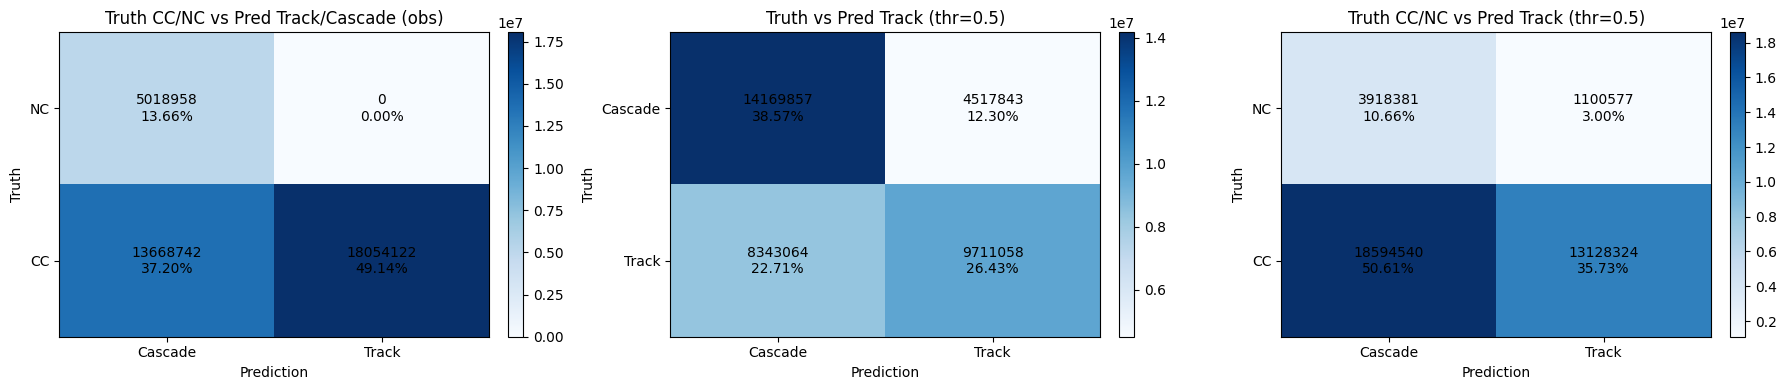

In [13]:
# We cannot measure NC vs CC, we can only say whether it's track-like or cascade-like.
# therefore we make the assumption that a track-like event is a CC muon neutrino, and all cascades are NC. 
# thus ignoring CC electron (and tau) neutrinos.

df = db_MC_neutrinos_cut #for ease of writing

CC_mask = df['interaction_type'] ==1        # Truth CC
NC_mask = df['interaction_type'] ==2        # Truth NC

track_mu_mask = df['track_mu'] == 1         # Assuming this means it is a tracklike- muon-neutrino
not_track_mu_mask = df['track_mu'] == 0     

TP = int((track_mu_mask & CC_mask).sum())
FP = int((track_mu_mask & NC_mask).sum())
FN = int((not_track_mu_mask & CC_mask).sum())
TN = int((not_track_mu_mask & NC_mask).sum())

# Rows represent Truth [NC, CC] and columns represent Prediction [Cascade, Track]
confusion_df = pd.DataFrame(
    [[TN, FP],
     [FN, TP]],
    index=['NC', 'CC'],
    columns=['Cascade', 'Track']
 )

print("Confusion matrix (counts): Truth CC/NC vs Cascade/Track")
display(confusion_df)

# Prepare second confusion matrix: Truth track_mu vs Predicted track_mu_pred
have_pred = 'track_mu_pred' in df.columns
thresh = 0.5
try:
    # Use existing notebook threshold if defined elsewhere
    thresh = float(track_cut)  # noqa: F821
except Exception:
    pass

if have_pred:
    pred_track_mask = (df['track_mu_pred'] >= thresh)
    pred_casc_mask = ~pred_track_mask
    true_track_mask = df['track_mu'] == 1
    true_casc_mask = df['track_mu'] == 0

    TP2 = int((pred_track_mask & true_track_mask).sum())
    FP2 = int((pred_track_mask & true_casc_mask).sum())
    FN2 = int((~pred_track_mask & true_track_mask).sum())
    TN2 = int((~pred_track_mask & true_casc_mask).sum())

    confusion_df_pred = pd.DataFrame(
        [[TN2, FP2],
         [FN2, TP2]],
        index=['Cascade', 'Track'],
        columns=['Cascade', 'Track']
    )

    # Prepare third confusion matrix: Truth interaction_type (NC/CC) vs Predicted track_mu_pred (Cascade/Track)
    TP3 = int((pred_track_mask & CC_mask).sum())
    FP3 = int((pred_track_mask & NC_mask).sum())
    FN3 = int((~pred_track_mask & CC_mask).sum())
    TN3 = int((~pred_track_mask & NC_mask).sum())
else:
    confusion_df_pred = None
    TP3 = FP3 = FN3 = TN3 = None

# Plot all confusion matrices side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Left: CC/NC vs Cascade/Track (using observed track_mu)
cm1 = np.array([[TN, FP],
                [FN, TP]])
im1 = axes[0].imshow(cm1, cmap='Blues', aspect='auto')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Cascade', 'Track'])
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['NC', 'CC'])
axes[0].set_xlabel('Prediction')
axes[0].set_ylabel('Truth')
for i in range(cm1.shape[0]):
    for j in range(cm1.shape[1]):
        count = cm1[i, j]
        pct = count / cm1.sum() if cm1.sum() else 0.0
        axes[0].text(j, i, f"{count}\n{pct:.2%}", ha='center', va='center', color='black')
axes[0].set_title('Truth CC/NC vs Pred Track/Cascade (obs)')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Middle: track_mu (truth) vs track_mu_pred (prediction)
if confusion_df_pred is not None:
    cm2 = np.array([[TN2, FP2],
                    [FN2, TP2]])
    im2 = axes[1].imshow(cm2, cmap='Blues', aspect='auto')
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(['Cascade', 'Track'])
    axes[1].set_yticks([0, 1])
    axes[1].set_yticklabels(['Cascade', 'Track'])
    axes[1].set_xlabel('Prediction')
    axes[1].set_ylabel('Truth')
    for i in range(cm2.shape[0]):
        for j in range(cm2.shape[1]):
            count = cm2[i, j]
            pct = count / cm2.sum() if cm2.sum() else 0.0
            axes[1].text(j, i, f"{count}\n{pct:.2%}", ha='center', va='center', color='black')
    axes[1].set_title(f'Truth vs Pred Track (thr={thresh:g})')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
else:
    axes[1].axis('off')
    axes[1].text(0.5, 0.5, "Column 'track_mu_pred' not found\nCannot build confusion matrix.",
                  ha='center', va='center', fontsize=10)

# Right: interaction_type (truth NC/CC) vs track_mu_pred (prediction)
if confusion_df_pred is not None and TP3 is not None:
    cm3 = np.array([[TN3, FP3],
                    [FN3, TP3]])
    im3 = axes[2].imshow(cm3, cmap='Blues', aspect='auto')
    axes[2].set_xticks([0, 1])
    axes[2].set_xticklabels(['Cascade', 'Track'])
    axes[2].set_yticks([0, 1])
    axes[2].set_yticklabels(['NC', 'CC'])
    axes[2].set_xlabel('Prediction')
    axes[2].set_ylabel('Truth')
    for i in range(cm3.shape[0]):
        for j in range(cm3.shape[1]):
            count = cm3[i, j]
            pct = count / cm3.sum() if cm3.sum() else 0.0
            axes[2].text(j, i, f"{count}\n{pct:.2%}", ha='center', va='center', color='black')
    axes[2].set_title(f'Truth CC/NC vs Pred Track (thr={thresh:g})')
    plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
else:
    axes[2].axis('off')
    axes[2].text(0.5, 0.5, "Column 'track_mu_pred' not found\nCannot build confusion matrix.",
                  ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [4]:
''' Copied from https://mceq.readthedocs.io/en/latest/examples/Simple_zenith_averaged_neutrinos.html'''

mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model 
# 
# (so only cosmic rays? problem?) ^^
#
# support a tuple (primary model class (not instance!), arguments)

primary_model = (pm.HillasGaisser2012, "H3a"),

theta_deg=0.0, #we average so it doesnt matter
)

#Power of energy to scale the flux
mag = 3 #doesnt matter for ratio

#obtain energy grid (fixed) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

#Dictionary for results
flux = {}

#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(1,0,11))*180./np.pi

#Initialize empty grid
for frac in ['numu_total',
             'nue_total','nutau_total']:
    flux[frac] = np.zeros_like(e_grid)


#Sum fluxes, calculated for different angles
for theta in angles:
    mceq_run.set_theta_deg(theta)
    mceq_run.solve()

    flux['numu_total'] += (mceq_run.get_solution('total_numu', mag)
                          + mceq_run.get_solution('total_antinumu', mag))

    flux['nue_total'] += (mceq_run.get_solution('total_nue', mag)
                         + mceq_run.get_solution('total_antinue', mag))


    # since there are no conventional tau neutrinos, prompt=total
    flux['nutau_total'] += (mceq_run.get_solution('total_nutau', mag)
                        + mceq_run.get_solution('total_antinutau', mag))

log_bincenters = mceq_run.e_grid[(mceq_run.e_grid > 1) & (mceq_run.e_grid < 1e4)]

# log_bins are bin centers, so calculate bin edges for log spacing
log_binedges = np.sqrt(log_bincenters[:-1] * log_bincenters[1:])
log_binedges = np.concatenate(([log_bincenters[0] * (log_bincenters[1]/log_bincenters[0])**-0.5], log_binedges, [log_bincenters[-1] * (log_bincenters[-1]/log_bincenters[-2])**0.5]))  # extrapolate edges

#average the results
for frac in ['numu_total',
             'nue_total','nutau_total']:
    flux[frac] = flux[frac]/float(len(angles))
    flux[frac] = np.array([val for i, val in enumerate(flux[frac]) if e_grid[i] in log_bincenters and val != 0])


MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [5]:
print(db_MC_neutrinos_cut.columns)

Index(['track_mu_pred', 'event_no', 'track_mu', 'energy_pred', 'energy',
       'zenith_pred', 'zenith_kappa', 'zenith', 'azimuth_pred',
       'azimuth_kappa', 'azimuth', 'pid_noise_pred', 'pid_muon_pred',
       'pid_neutrino_pred', 'pid', 'pid_neutrino_pred_logit',
       'position_x_pred', 'position_y_pred', 'position_z_pred', 'position_x',
       'position_y', 'position_z', 'N_pulses', 'N_string', 'N_doms',
       'First_dom_time', 'C2HR6', 'CausalVetoHits', 'CleanedFullTimeLength',
       'DCFiducialHits', 'L3_oscNext_bool', 'NAbove200Hits', 'NchCleaned',
       'NoiseEngineNoCharge', 'RTVetoCutHit', 'STW9000_DTW300Hits',
       'UncleanedFullTimeLength', 'VertexGuessZ', 'VetoFiducialRatioHits',
       'interaction_type', 'total_osc_weight'],
      dtype='object')


KeyboardInterrupt: 

KeyboardInterrupt: 

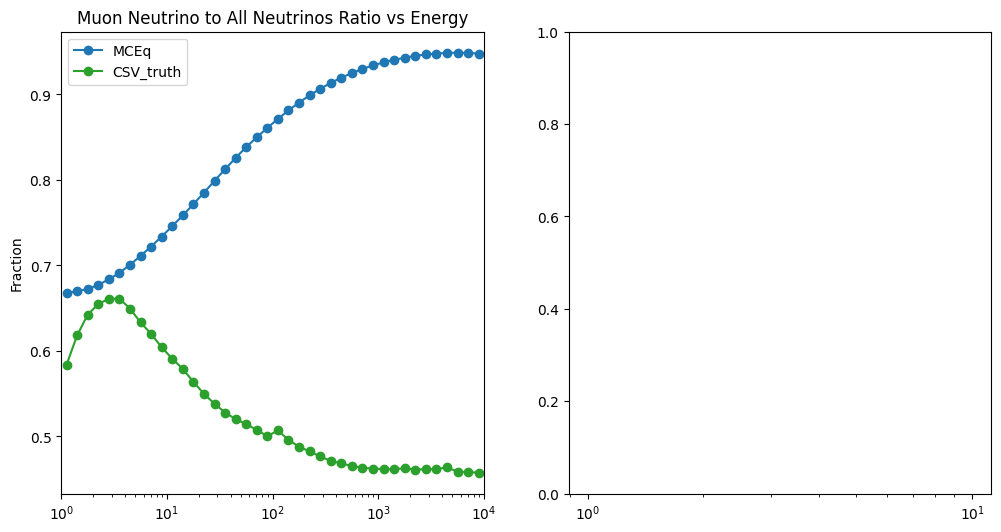

In [6]:
track_cut = 0.5

true_muon_to_total_list = []

NC_list = []
CC_list = []

track_list = []
casc_list = []

for i in range(len(log_bincenters)):
    db_in_bin = db_MC_neutrinos_cut[(db_MC_neutrinos_cut['energy'] > log_binedges[i]) & (db_MC_neutrinos_cut['energy'] <= log_binedges[i+1])]

    true_taus = len(db_in_bin[abs(db_in_bin['pid']) == 16])
    true_muons = len(db_in_bin[abs(db_in_bin['pid']) == 14])
    true_elecs = len(db_in_bin[abs(db_in_bin['pid']) == 12])
    true_muon_to_total_list.append(true_muons / (true_taus+true_muons+true_elecs))
    
    CC = len(db_in_bin[db_in_bin['interaction_type'] == 1])
    NC = len(db_in_bin[db_in_bin['interaction_type'] == 2])
    NC_list.append(NC)
    CC_list.append(CC)

    tracks = len(db_in_bin[db_in_bin['track_mu'] == 1])
    track_list.append(tracks)
    cascs = len(db_in_bin[db_in_bin['track_mu'] == 0])
    casc_list.append(cascs)


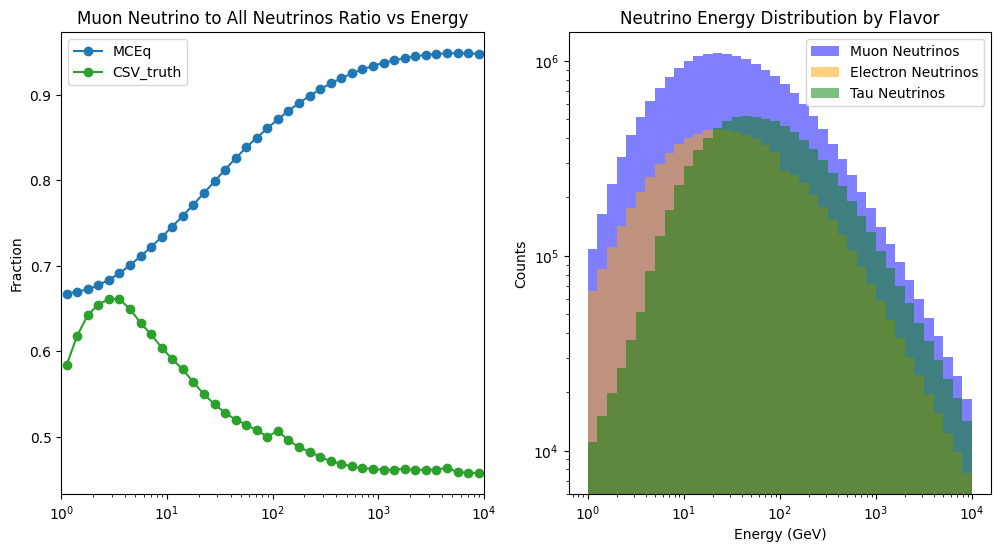

In [7]:
mu_to_all = flux['numu_total']/(flux['nue_total']+flux['numu_total']+flux['nutau_total'])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(log_bincenters, mu_to_all, marker='o', label='MCEq', color='tab:blue')

ax[0].set_ylabel('Fraction')
ax[0].set_title('Muon Neutrino to All Neutrinos Ratio vs Energy')

ax[0].plot(log_bincenters, true_muon_to_total_list, marker='o', label='CSV_truth', color='tab:green')
ax[0].set_xlim([1, 10000])
ax[0].set_xscale('log')
ax[0].legend()

bins = np.logspace(np.log10(db_MC_neutrinos_cut['energy'].min()), np.log10(db_MC_neutrinos_cut['energy'].max()), 41)
ax[1].set_xscale('log')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 14]['energy'], bins=bins, alpha=0.5, label='Muon Neutrinos', color='blue')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 12]['energy'], bins=bins, alpha=0.5, label='Electron Neutrinos', color='orange')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 16]['energy'], bins=bins, alpha=0.5, label='Tau Neutrinos', color='green')
ax[1].set_xlabel('Energy (GeV)')
ax[1].set_yscale('log')
ax[1].set_ylabel('Counts')
ax[1].set_title('Neutrino Energy Distribution by Flavor')
ax[1].legend()

print(mu_to_all)
print(log_bincenters)
print(true_muon_to_total_list)
plt.show()

In [ ]:

# Define quark list and their (I3, Q) values
_quarks = {
    'u': {'I3':  0.5, 'Q':  2/3},
    'c': {'I3':  0.5, 'Q':  2/3},
    'd': {'I3': -0.5, 'Q': -1/3},
    's': {'I3': -0.5, 'Q': -1/3},
    'b': {'I3': -0.5, 'Q': -1/3},
    # top quark not included (threshold very high, negligible PDF in nucleon at relevant x)
}

def gL_gR_for_quark(q, sin2w):
    """Return (gL, gR) for quark q given sin^2(theta_W)."""
    I3 = _quarks[q]['I3']
    Q  = _quarks[q]['Q']
    gL = I3 - Q * sin2w
    gR = - Q * sin2w
    return gL, gR

def coupling_squared_sum(sin2w):
    """
    Compute S(sin2w) = sum_q w_q * (gL^2 + gR^2)
    If weights is None, use equal weights for each quark in _quarks.
    weights should be a dict mapping quark->weight (nonnegative).
    """
    S = 0.0
    for q in _quarks.keys():
        gL, gR = gL_gR_for_quark(q, sin2w)
        S += (gL**2 + gR**2)
    return S

def R_of_sin2w(sin2w, sin2w_ref=0.23126):
    """
    Return scaling factor R(sin2w) = S(sin2w) / S(sin2w_ref)
    where S = sum_q w_q (gL^2 + gR^2).
    """
    S_ref = coupling_squared_sum(sin2w_ref)
    S = coupling_squared_sum(sin2w)
    return S / S_ref

def scale_sigma_NC(sigma_NC_ref, sin2w, sin2w_ref=0.2229):
    """
    Scale a reference sigma_NC (scalar or numpy array) by R(sin2w).
    Returns scaled sigma_NC for same shape as sigma_NC_ref.
    """
    R = R_of_sin2w(sin2w, sin2w_ref=sin2w_ref)
    return np.array(sigma_NC_ref) * float(R), float(R)

#0.2229 from standard model 1- (Mw)/(Mz)^2 


# ----------------------- Demo / sanity checks -----------------------
# Toy reference sigma_NC(E) (units arbitrary) as a function of energy.
energies = np.array([50, 100, 200, 500, 1000, 2000, 5000])  # GeV

sigma_NC_ref = np.array([0.10, 0.20, 0.41, 1.0, 2.0, 3.8, 8.6]) * 1e-36  #from paper

# Compute scaling factors for a few sin2w choices
sin2w_values = [0.220, 0.2229, 0.23126, 0.240]
results = []
for s in sin2w_values:
    scaled_sigma, R = scale_sigma_NC(sigma_NC_ref, s)
    results.append({'sin2w': s, 'R': R})

# Print results
print("Coupling-squared scaling factors R(sin2w) (equal-quark weights):")
for r in results:
    print(f"  sin^2(theta_W) = {r['sin2w']:.6f}  ->  R = {r['R']:.6f}")

# Show an example scaled sigma at E = 1e6 GeV (index 4)
idx_example = 4
print("\nExample at E = {:.2g} GeV:".format(energies[idx_example]))
print("  sigma_NC_ref = {:.3e} cm^2".format(sigma_NC_ref[idx_example]))
for r in results:
    scaled_sigma, R = scale_sigma_NC(sigma_NC_ref[idx_example], r['sin2w'])
    print(f"  sin2w={r['sin2w']:.6f} -> scaled sigma_NC = {scaled_sigma:.3e} cm^2 (R={R:.6f})")


Coupling-squared scaling factors R(sin2w) (equal-quark weights):
  sin^2(theta_W) = 0.220000  ->  R = 1.004260
  sin^2(theta_W) = 0.222900  ->  R = 1.000000
  sin^2(theta_W) = 0.231260  ->  R = 0.987989
  sin^2(theta_W) = 0.240000  ->  R = 0.975861

Example at E = 1e+03 GeV:
  sigma_NC_ref = 2.000e-36 cm^2
  sin2w=0.220000 -> scaled sigma_NC = 2.009e-36 cm^2 (R=1.004260)
  sin2w=0.222900 -> scaled sigma_NC = 2.000e-36 cm^2 (R=1.000000)
  sin2w=0.231260 -> scaled sigma_NC = 1.976e-36 cm^2 (R=0.987989)
  sin2w=0.240000 -> scaled sigma_NC = 1.952e-36 cm^2 (R=0.975861)


[0.06537285 0.08231132 0.11028718 0.14512712 0.18964139 0.24180689
 0.30541466 0.37831213 0.45156549 0.5289028  0.60368354 0.6774026
 0.73423738 0.7765813  0.80085888 0.81436592 0.81907572 0.82047727
 0.81476495 0.803644   0.80444415 0.77414097 0.7423896  0.71390562
 0.6853841  0.6625039  0.64115032 0.62668985 0.61190066 0.60399079
 0.60407114 0.60132931 0.6037061  0.59772804 0.59903005 0.60209626
 0.61060955 0.60445444 0.61453372 0.62626752]
[1.12201845e+00 1.41253754e+00 1.77827941e+00 2.23872114e+00
 2.81838293e+00 3.54813389e+00 4.46683592e+00 5.62341325e+00
 7.07945784e+00 8.91250938e+00 1.12201845e+01 1.41253754e+01
 1.77827941e+01 2.23872114e+01 2.81838293e+01 3.54813389e+01
 4.46683592e+01 5.62341325e+01 7.07945784e+01 8.91250938e+01
 1.12201845e+02 1.41253754e+02 1.77827941e+02 2.23872114e+02
 2.81838293e+02 3.54813389e+02 4.46683592e+02 5.62341325e+02
 7.07945784e+02 8.91250938e+02 1.12201845e+03 1.41253754e+03
 1.77827941e+03 2.23872114e+03 2.81838293e+03 3.54813389e+03
 4.4

[0.06537285 0.08231132 0.11028718 0.14512712 0.18964139 0.24180689
 0.30541466 0.37831213 0.45156549 0.5289028  0.60368354 0.6774026
 0.73423738 0.7765813  0.80085888 0.81436592 0.81907572 0.82047727
 0.81476495 0.803644   0.80444415 0.77414097 0.7423896  0.71390562
 0.6853841  0.6625039  0.64115032 0.62668985 0.61190066 0.60399079
 0.60407114 0.60132931 0.6037061  0.59772804 0.59903005 0.60209626
 0.61060955 0.60445444 0.61453372 0.62626752]
[1.12201845e+00 1.41253754e+00 1.77827941e+00 2.23872114e+00
 2.81838293e+00 3.54813389e+00 4.46683592e+00 5.62341325e+00
 7.07945784e+00 8.91250938e+00 1.12201845e+01 1.41253754e+01
 1.77827941e+01 2.23872114e+01 2.81838293e+01 3.54813389e+01
 4.46683592e+01 5.62341325e+01 7.07945784e+01 8.91250938e+01
 1.12201845e+02 1.41253754e+02 1.77827941e+02 2.23872114e+02
 2.81838293e+02 3.54813389e+02 4.46683592e+02 5.62341325e+02
 7.07945784e+02 8.91250938e+02 1.12201845e+03 1.41253754e+03
 1.77827941e+03 2.23872114e+03 2.81838293e+03 3.54813389e+03
 4.4

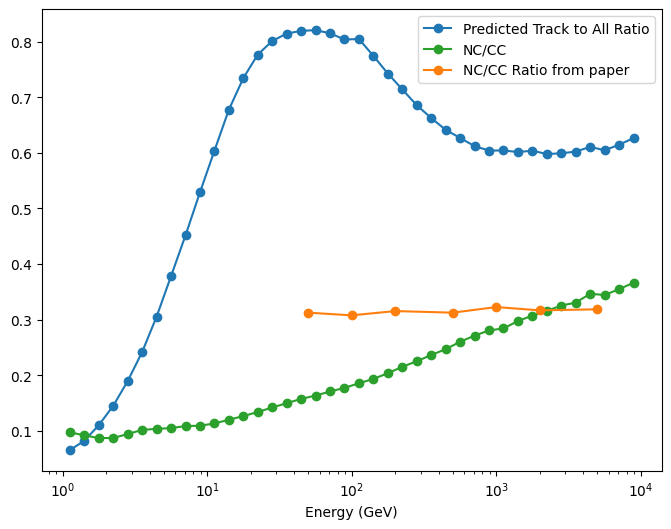

In [ ]:
ratio = (np.array(NC_list))/(np.array(CC_list))

pred_ratio =   (np.array(casc_list))/np.array(track_list)

sigma_cc = np.array([0.32, 0.65, 1.3, 3.2, 6.2, 12, 27]) * 1e-36
sigma_nc = np.array([0.10, 0.20, 0.41, 1.0, 2.0, 3.8, 8.6]) * 1e-36
energies_list = np.array([50, 100, 200, 500, 1000, 2000, 5000])  # GeV

true_ratio = sigma_nc / sigma_cc

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(log_bincenters, pred_ratio, marker='o', label='Predicted Track to All Ratio', color='tab:blue')
ax.plot(log_bincenters, ratio, marker='o', label='NC/CC', color='tab:green')
ax.plot(energies_list, true_ratio, marker='o', label='NC/CC Ratio from paper', color='tab:orange')
ax.set_xlabel('Energy (GeV)')
ax.set_xscale('log')
ax.legend()


print(pred_ratio)
print(log_bincenters)
print(ratio)
print(log_bincenters)
print(true_ratio)
print(energies_list)